### Import important libirary

In [2]:
import gym
import sys
import numpy as np
import matplotlib.pyplot as plt
from stable_baselines3 import DQN
from stable_baselines3.common.logger import Logger, HumanOutputFormat
from stable_baselines3.common.evaluation import evaluate_policy
from env3 import TreasureHuntEnv  

###  DQN Setup with Custom Logger for TreasureHuntEnv

In [13]:
class DummyLogger(Logger):
    def __init__(self):
        super().__init__(None, [HumanOutputFormat(sys.stdout)])

env = TreasureHuntEnv(size=9, max_steps=500, lives=3, special_duration=20)

model = DQN(
    'MultiInputPolicy',  
    env, 
    verbose=0, 
    learning_rate=0.001,  
    gamma=0.99, 
    buffer_size=50000,  
    target_update_interval=1000,  
    train_freq=32,  
    batch_size=32, 
)

model._logger = DummyLogger()

### Training Loop for DQN on TreasureHuntEnv

In [15]:
import numpy as np

rewards_per_episode = []
loss_per_episode = []
best_total_reward = -np.inf

num_episodes = 500
epsilon = 1.0  # initial epsilon
epsilon_min = 0.02
epsilon_decay = 0.995

for episode in range(num_episodes):
    state = env.reset()[0]  # Get only the observation from reset
    
    total_reward = 0
    total_loss = 0
    done = False
    truncated = False
    
    while not (done or truncated):
        # Epsilon-Greedy approach
        if np.random.rand() < epsilon:
            action = env.action_space.sample()  # Fixed typo here
        else:
            action, _ = model.predict(state, deterministic=True)
            action = int(action)
            
        # Take action in the environment
        next_state, reward, done, truncated, info = env.step(action)
            
        # Store transition in the replay buffer
        # The key fix: Properly format data for the replay buffer
        if model.replay_buffer is not None:
            # For DictReplayBuffer
            if hasattr(model.replay_buffer, 'obs_shape') and isinstance(model.replay_buffer.obs_shape, dict):
                if not isinstance(state, dict):
                    state_dict = {'obs': np.array([state])}
                else:
                    state_dict = {k: np.array([v]) if np.isscalar(v) else v for k, v in state.items()}
                
                if not isinstance(next_state, dict):
                    next_state_dict = {'obs': np.array([next_state])}
                else:
                    next_state_dict = {k: np.array([v]) if np.isscalar(v) else v for k, v in next_state.items()}
                
                model.replay_buffer.add(
                    state_dict,
                    next_state_dict,
                    np.array([action]),
                    reward,
                    done,
                    [info]
                )
            # For regular ReplayBuffer
            else:
                model.replay_buffer.add(
                    state,
                    next_state,
                    np.array([action]),
                    reward,
                    done,
                    [info]
                )
            
        # Move to the next state
        state = next_state
        
        # Accumulate reward
        total_reward += reward
        
        # Train the model
        if model.replay_buffer.size() > model.batch_size:
            loss = model.train(gradient_steps=1, batch_size=32)
            total_loss = loss.get("loss", 0) if loss is not None else 0
        else:
            total_loss = 0
    
    # Store episode metrics
    rewards_per_episode.append(total_reward)
    loss_per_episode.append(total_loss)
    
    # Save best model
    if total_reward > best_total_reward:
        best_total_reward = total_reward
        model.save("best_dqn_Treasure")
        print("New best model saved!")
    
    # Decay epsilon
    epsilon = max(epsilon_min, epsilon * epsilon_decay)
    
    # Logging
    print(f"Episode {episode}, Reward: {total_reward}, Loss: {total_loss}, Epsilon: {epsilon:.4f}")

New best model saved!
Episode 0, Reward: -340, Loss: 0, Epsilon: 0.9950
New best model saved!
Episode 1, Reward: -156, Loss: 0, Epsilon: 0.9900
Episode 2, Reward: -235, Loss: 0, Epsilon: 0.9851
Episode 3, Reward: -251, Loss: 0, Epsilon: 0.9801
New best model saved!
Episode 4, Reward: 86, Loss: 0, Epsilon: 0.9752
Episode 5, Reward: -14, Loss: 0, Epsilon: 0.9704
Episode 6, Reward: -691, Loss: 0, Epsilon: 0.9655
Episode 7, Reward: -795, Loss: 0, Epsilon: 0.9607
Episode 8, Reward: -508, Loss: 0, Epsilon: 0.9559
Episode 9, Reward: -367, Loss: 0, Epsilon: 0.9511
Episode 10, Reward: -139, Loss: 0, Epsilon: 0.9464
Episode 11, Reward: 21, Loss: 0, Epsilon: 0.9416
Episode 12, Reward: -88, Loss: 0, Epsilon: 0.9369
New best model saved!
Episode 13, Reward: 124, Loss: 0, Epsilon: 0.9322
Episode 14, Reward: -132, Loss: 0, Epsilon: 0.9276
Episode 15, Reward: -247, Loss: 0, Epsilon: 0.9229
Episode 16, Reward: -209, Loss: 0, Epsilon: 0.9183
Episode 17, Reward: 100, Loss: 0, Epsilon: 0.9137
Episode 18, 

### Performance Visualization & Evaluation

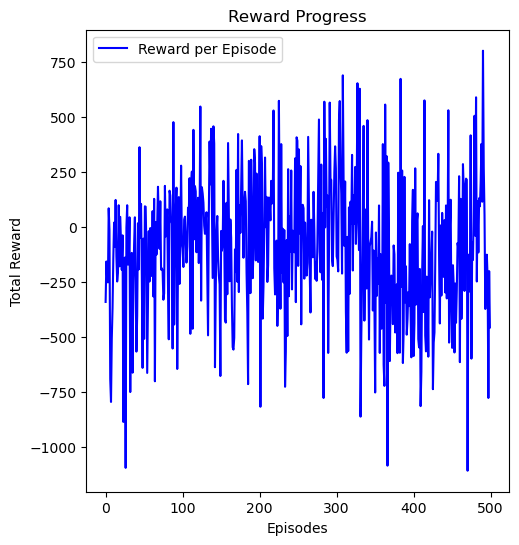

Mean reward: -94.32 +/- 188.67


In [ ]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(rewards_per_episode, label="Reward per Episode", color="blue")
plt.xlabel("Episodes")
plt.ylabel("Total Reward")
plt.title("Reward Progress")
plt.legend()


plt.show()

mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=100)
print(f"Mean reward: {mean_reward:.2f} +/- {std_reward:.2f}")



In [4]:
import numpy as np
import time
import matplotlib.pyplot as plt
from stable_baselines3 import DQN
from env3 import TreasureHuntEnv

def run_evaluation(model_path, num_trials=5, render_delay=0.1):
    # Create environment with human rendering mode
    env = TreasureHuntEnv(size=9, max_steps=500, lives=3, special_duration=20, render_mode='human')

    try:
        # Load the trained model from zip file
        model = DQN.load(model_path)
        print(f"\nSuccessfully loaded model from {model_path}")
        
        # Print observation space information for debugging
        print("\nObservation Space Info:")
        print(f"Grid shape: {env.observation_space['grid'].shape}")
        print(f"Grid low: {env.observation_space['grid'].low}")
        print(f"Grid high: {env.observation_space['grid'].high}")
        print(f"Agent pos space: {env.observation_space['agent_pos']}")
        print(f"Steps left space: {env.observation_space['steps_left']}")
        print(f"Lives space: {env.observation_space['lives']}")
        print(f"Special treasures space: {env.observation_space['special_treasures'].shape}")
        
    except Exception as e:
        print(f"\nError loading model: {e}")
        return

    # Initialize tracking lists
    all_rewards = []
    all_steps = []
    all_treasures = []
    all_special = []
    all_rewards_by_type = []

    try:
        print("\nStarting evaluation with GUI rendering...")
        print("Press Ctrl+C to stop if needed.")
        
        for trial in range(1, num_trials + 1):
            print(f"\n=== Starting Trial {trial}/{num_trials} ===")
            
            # Reset environment and render initial state
            obs, _ = env.reset()
            env.render()
            time.sleep(0.5)
            
            # Initialize episode variables
            done = False
            truncated = False
            total_reward = 0
            step_count = 0
            treasures_collected = 0
            special_collected = 0
            
            while not (done or truncated):
                # Get and perform action
                action, _ = model.predict(obs, deterministic=True)
                # Convert action to integer
                action = int(action.item())  # Add this line to convert numpy array to integer
                
                next_obs, reward, done, truncated, info = env.step(action)
                env.render()
                
                # Track events
                if 'event' in info:
                    events = info['event'].split()
                    for event in events:
                        if 'treasure_collected' in event:
                            treasures_collected += 1
                            print(f"Step {step_count}: Treasure collected!")
                        elif 'special_collected' in event:
                            special_collected += 1
                            print(f"Step {step_count}: Special treasure collected!")
                        elif 'trapped' in event:
                            print(f"Step {step_count}: Hit a trap!")
                        elif 'caught' in event:
                            print(f"Step {step_count}: Caught by enemy!")
                
                # Update state and counters
                obs = next_obs
                total_reward += reward
                step_count += 1
                time.sleep(render_delay)
            
            # Store trial results
            all_rewards.append(total_reward)
            all_steps.append(step_count)
            all_treasures.append(treasures_collected)
            all_special.append(special_collected)
            if 'rewards_by_type' in info:
                all_rewards_by_type.append(info['rewards_by_type'])
            
            # Print trial results
            print(f"\nTrial {trial} Results:")
            print(f"Total reward: {total_reward:.1f}")
            print(f"Steps taken: {step_count}")
            print(f"Treasures collected: {treasures_collected}")
            print(f"Special treasures collected: {special_collected}")
            if 'rewards_by_type' in info:
                print(f"Rewards by type: {info['rewards_by_type']}")
            print("=== Trial Complete ===\n")
            
            time.sleep(0.5)

    except KeyboardInterrupt:
        print("\nEvaluation interrupted by user.")
    except Exception as e:
        print(f"\nError during evaluation: {e}")
        import traceback
        traceback.print_exc()
    finally:
        env.close()
        print("\nEnvironment closed.")

if __name__ == "__main__":
    run_evaluation("best_dqn_Treasure.zip")


Successfully loaded model from best_dqn_Treasure.zip

Observation Space Info:
Grid shape: (9, 9)
Grid low: [[0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]]
Grid high: [[5 5 5 5 5 5 5 5 5]
 [5 5 5 5 5 5 5 5 5]
 [5 5 5 5 5 5 5 5 5]
 [5 5 5 5 5 5 5 5 5]
 [5 5 5 5 5 5 5 5 5]
 [5 5 5 5 5 5 5 5 5]
 [5 5 5 5 5 5 5 5 5]
 [5 5 5 5 5 5 5 5 5]
 [5 5 5 5 5 5 5 5 5]]
Agent pos space: MultiDiscrete([9 9])
Steps left space: Discrete(501)
Lives space: Discrete(4)
Special treasures space: (81, 2)

Starting evaluation with GUI rendering...
Press Ctrl+C to stop if needed.

=== Starting Trial 1/5 ===
Step 0: Treasure collected!
Step 1: Treasure collected!
Step 16: Treasure collected!
Step 18: Treasure collected!
Step 19: Treasure collected!
Step 21: Treasure collected!
Step 61: Treasure collected!
Step 184: Treasure collected!
Step 198: Special treasure collected!
S